<a href="https://colab.research.google.com/github/skhabiri/DS-Unit-2-Kaggle-Challenge/blob/master/module3-cross-validation/skhabiri_LS_DS_223_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*Unit 2, Sprint 2, Module 3*

---

# Cross-Validation


## Assignment
- [ ] [Review requirements for your portfolio project](https://lambdaschool.github.io/ds/unit2), then submit your dataset.
- [ ] Continue to participate in our Kaggle challenge. 
- [ ] Use scikit-learn for hyperparameter optimization with RandomizedSearchCV.
- [ ] Submit your predictions to our Kaggle competition. (Go to our Kaggle InClass competition webpage. Use the blue **Submit Predictions** button to upload your CSV file. Or you can use the Kaggle API to submit your predictions.)
- [ ] Commit your notebook to your fork of the GitHub repo.


**You can't just copy** from the lesson notebook to this assignment.

- Because the lesson was **regression**, but the assignment is **classification.**
- Because the lesson used [TargetEncoder](https://contrib.scikit-learn.org/categorical-encoding/targetencoder.html), which doesn't work as-is for _multi-class_ classification.

So you will have to adapt the example, which is good real-world practice.

1. Use a model for classification, such as [RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)
2. Use hyperparameters that match the classifier, such as `randomforestclassifier__ ...`
3. Use a metric for classification, such as [`scoring='accuracy'`](https://scikit-learn.org/stable/modules/model_evaluation.html#common-cases-predefined-values)
4. If you’re doing a multi-class classification problem — such as whether a waterpump is functional, functional needs repair, or nonfunctional — then use a categorical encoding that works for multi-class classification, such as [OrdinalEncoder](https://contrib.scikit-learn.org/categorical-encoding/ordinal.html) (not [TargetEncoder](https://contrib.scikit-learn.org/categorical-encoding/targetencoder.html))



## Stretch Goals

### Reading
- Jake VanderPlas, [Python Data Science Handbook, Chapter 5.3](https://jakevdp.github.io/PythonDataScienceHandbook/05.03-hyperparameters-and-model-validation.html), Hyperparameters and Model Validation
- Jake VanderPlas, [Statistics for Hackers](https://speakerdeck.com/jakevdp/statistics-for-hackers?slide=107)
- Ron Zacharski, [A Programmer's Guide to Data Mining, Chapter 5](http://guidetodatamining.com/chapter5/), 10-fold cross validation
- Sebastian Raschka, [A Basic Pipeline and Grid Search Setup](https://github.com/rasbt/python-machine-learning-book/blob/master/code/bonus/svm_iris_pipeline_and_gridsearch.ipynb)
- Peter Worcester, [A Comparison of Grid Search and Randomized Search Using Scikit Learn](https://blog.usejournal.com/a-comparison-of-grid-search-and-randomized-search-using-scikit-learn-29823179bc85)

### Doing
- Add your own stretch goals!
- Try other [categorical encodings](https://contrib.scikit-learn.org/categorical-encoding/). See the previous assignment notebook for details.
- In additon to `RandomizedSearchCV`, scikit-learn has [`GridSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html). Another library called scikit-optimize has [`BayesSearchCV`](https://scikit-optimize.github.io/notebooks/sklearn-gridsearchcv-replacement.html). Experiment with these alternatives.
- _[Introduction to Machine Learning with Python](http://shop.oreilly.com/product/0636920030515.do)_ discusses options for "Grid-Searching Which Model To Use" in Chapter 6:

> You can even go further in combining GridSearchCV and Pipeline: it is also possible to search over the actual steps being performed in the pipeline (say whether to use StandardScaler or MinMaxScaler). This leads to an even bigger search space and should be considered carefully. Trying all possible solutions is usually not a viable machine learning strategy. However, here is an example comparing a RandomForestClassifier and an SVC ...

The example is shown in [the accompanying notebook](https://github.com/amueller/introduction_to_ml_with_python/blob/master/06-algorithm-chains-and-pipelines.ipynb), code cells 35-37. Could you apply this concept to your own pipelines?


### BONUS: Stacking!

Here's some code you can use to "stack" multiple submissions, which is another form of ensembling:

```python
import pandas as pd

# Filenames of your submissions you want to ensemble
files = ['submission-01.csv', 'submission-02.csv', 'submission-03.csv']

target = 'status_group'
submissions = (pd.read_csv(file)[[target]] for file in files)
ensemble = pd.concat(submissions, axis='columns')
majority_vote = ensemble.mode(axis='columns')[0]

sample_submission = pd.read_csv('sample_submission.csv')
submission = sample_submission.copy()
submission[target] = majority_vote
submission.to_csv('my-ultimate-ensemble-submission.csv', index=False)
```

In [1]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://github.com/skhabiri/PredictiveModeling-TreeBasedModels-u2s2/tree/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [2]:
import pandas as pd
import numpy as np

# Merge train_features.csv & train_labels.csv
train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))

# Read test_features.csv & sample_submission.csv
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')

In [3]:
train.shape, test.shape

((59400, 41), (14358, 40))

In [4]:
# Tuning parameters
zero_cols = ["longitude", "latitude", "amount_tsh", "gps_height"]
# zero_cols = [, "longitude", "latitude", "population", "construction_year" ]
# drop_cols=[]"num_private", 
drop_cols = ["waterpoint_type_group", "source_type",
             "quantity_group", "quality_group", "payment_type", "management_group", 
             "extraction_type_group", "recorded_by"]
# In category reduction of each categorical feature {#"others"+offset < sum(#"kept_values")}
offset = 1

# only categorical features with maximum num_card value of cardinality are kept
num_card = 100
# decision tree depth
num_depth =16

In [5]:
# Split train into train & val
# from sklearn.model_selection import train_test_split

# train, val = train_test_split(train, train_size=0.80, test_size=0.20, 
#                               stratify=train['status_group'], random_state=42)

# train.shape, val.shape, test.shape

In [6]:
# The status_group column is the target
target = 'status_group'

# Get a dataframe with all train columns except the target & id
train_features = train.drop(columns=[target, 'id'])

# Arrange data into X features matrix and y target vector 
X_train = train[train_features.columns]
y_train = train[target]

X_test = test[train_features.columns]

In [7]:
X_train.shape, X_test.shape

((59400, 39), (14358, 39))

In [8]:
def zero_to_nan(df, col_list):
  zero_list = [0, "0", -2.000000e-08]
  for col in col_list:
    df.loc[df[col].isin(zero_list), col] = np.NaN
  return df

In [9]:
# nonnum_features = X_train.select_dtypes(exclude='number').columns.to_list()
# numeric_features = X_train.select_dtypes(include='number').columns.to_list()

In [10]:
def wrangle2(df, zero_cols, drop_cols):
  df["date_recorded"] = pd.to_datetime(df["date_recorded"], infer_datetime_format=True).dt.year
  df = zero_to_nan(df, zero_cols)
  df = df.drop(drop_cols, axis=1)
  return df

In [11]:
X_train = wrangle2(X_train, zero_cols, drop_cols)
X_test = wrangle2(X_test, zero_cols, drop_cols)

/Users/shahnam/.pyenv/versions/3.7.8/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/shahnam/.pyenv/versions/3.7.8/lib/python3.7/site-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


In [12]:
nonnum_features = X_train.select_dtypes(exclude='number').columns.to_list()
numeric_features = X_train.select_dtypes(include='number').columns.to_list()

In [13]:
# reduces number of the categories
def cat_comb(train, testval_list, col_list, offset):
  '''
  ex/ cat_comb(train, [validation, test] [col1, col2])
  '''
  df = train.copy()
  test_list = testval_list.copy()
  for col_name in col_list:
    cat_ser = df[col_name].value_counts(sort=True, ascending=False, dropna=False)
    # make sure other category is less than sum of predecessors
    for i in range(len(cat_ser)):
      if cat_ser[:i+1].sum() < (cat_ser[i+1:].sum() + offset):
        continue
      else:
        n_cat = i+2
        break
  
    cat_keep = list(cat_ser[:n_cat-1].index)
    df.loc[~df[col_name].isin(cat_keep), col_name] = "other"
    
    # alternative, very slow .replace method
    # mask = ~df[col_name].isin(cat_keep)
    # df[col_name] = df[col_name].replace(mask, "other")


    for df_i in test_list:
      df_i.loc[~df_i[col_name].isin(cat_keep), col_name] = "other"
  
    # alternative way, but could get a size issue with test or validation data
    # cat_bool = ~(df[col_name].isin(cat_ser.index[:n_cat-1]))
    # df.loc[cat_bool, col_name] = "other"
  return df, test_list

In [14]:
X_train.shape, X_test.shape

((59400, 31), (14358, 31))

In [15]:
X_train, X_test_list = cat_comb(X_train, [X_test], nonnum_features, offset)
X_test = X_test_list[0]

In [16]:
def make_feat(train_df, num_card):
  # Get a list of the numeric features
  numeric_features = train_df.select_dtypes(include='number').columns.to_list()

  nonnum_features = train_df.columns[~train_df.columns.isin(numeric_features)].to_list()
  # nonnum_features = train_df.select_dtypes(exclude='number').columns

  assert len(numeric_features) + len(nonnum_features) == len(train_df.columns)

  # Get a series with the cardinality of the nonnumeric features
  cardinality = train_df.select_dtypes(exclude='number').nunique()
  print(cardinality.sort_values())
  # Get a list of all categorical features with cardinality <= num_cat
  categorical_features = cardinality[cardinality <= num_card].index.to_list()
  # Combine the lists 
  features = numeric_features + categorical_features
  return features, numeric_features, categorical_features

In [17]:
features, numeric_features, categorical_features = make_feat(X_train, num_card);

quantity                    2
water_quality               2
management                  2
public_meeting              2
scheme_management           2
source_class                2
permit                      2
waterpoint_type             3
source                      3
payment                     3
extraction_type_class       3
extraction_type             3
scheme_name                 4
basin                       5
region                      8
installer                  11
funder                     16
lga                        34
ward                      418
subvillage               2426
wpt_name                 7702
dtype: int64


In [18]:
X_train.shape, X_test.shape

((59400, 31), (14358, 31))

In [19]:
# Arrange data into X features matrix and y target vector 
X_train = X_train[features]
X_test = X_test[features]

In [20]:
X_train.shape, X_test.shape

((59400, 28), (14358, 28))

In [21]:
import category_encoders as ce
# from category_encoders import OneHotEncoder, OrdinalEncoder

from sklearn.impute import SimpleImputer

from sklearn.preprocessing import StandardScaler

from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif

from sklearn.pipeline import make_pipeline, Pipeline

# from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV



In [22]:
X_train.columns

Index(['amount_tsh', 'date_recorded', 'gps_height', 'longitude', 'latitude',
       'num_private', 'region_code', 'district_code', 'population',
       'construction_year', 'funder', 'installer', 'basin', 'region', 'lga',
       'public_meeting', 'scheme_management', 'scheme_name', 'permit',
       'extraction_type', 'extraction_type_class', 'management', 'payment',
       'water_quality', 'quantity', 'source', 'source_class',
       'waterpoint_type'],
      dtype='object')

### Cross Validation and hyper parameter tuning

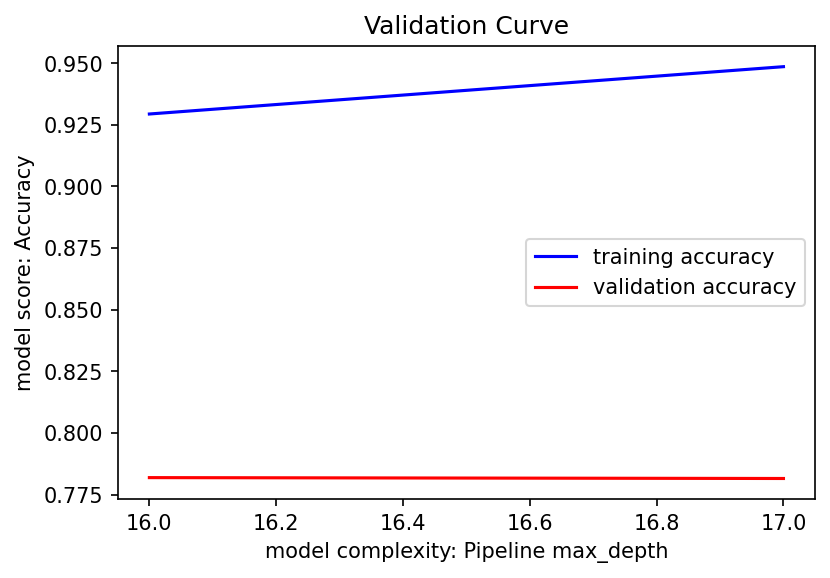

In [23]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.model_selection import validation_curve
from sklearn.tree import DecisionTreeClassifier

pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(), 
    # SelectKBest(f_classif), 
    # DecisionTreeClassifier(max_depth=13, min_samples_split=2)
    RandomForestClassifier(random_state=42, min_samples_split=2, n_estimators=200)

)
par_name = "max_depth"
# par_range = [2**i for i in range(0,11,1)]
par_range = range(16,18,1)
train_scores, val_scores = validation_curve(
    pipeline, X_train, y_train,
    # param_name='decisiontreeclassifier__'+ par_name, 
    # param_name='selectkbest__'+ par_name, 
    param_name='randomforestclassifier__'+ par_name, 

    param_range=par_range, scoring='accuracy', 
    cv=2,
    n_jobs=-1
)

plt.figure(dpi=150)
plt.plot(par_range, np.mean(train_scores, axis=1), color='blue', label='training accuracy')
plt.plot(par_range, np.mean(val_scores, axis=1), color='red', label='validation accuracy')
plt.title('Validation Curve')
plt.xlabel(f'model complexity: Pipeline {par_name}')
plt.ylabel('model score: Accuracy')
plt.legend();

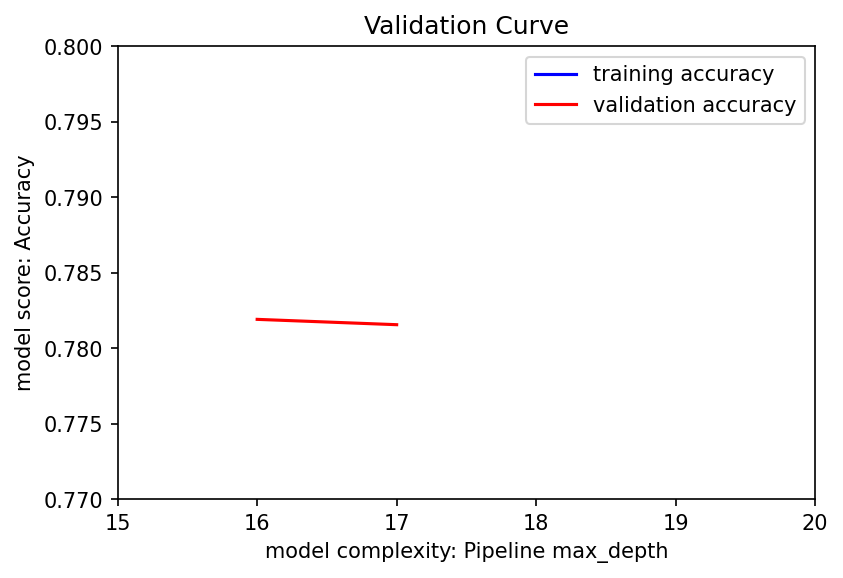

In [24]:
plt.figure(dpi=150)
plt.plot(par_range, np.mean(train_scores, axis=1), color='blue', label='training accuracy')
plt.plot(par_range, np.mean(val_scores, axis=1), color='red', label='validation accuracy')
plt.title('Validation Curve')
plt.xlabel(f'model complexity: Pipeline {par_name}')
plt.ylabel('model score: Accuracy')
plt.ylim((.77, .8))  # Zoom in
plt.xlim((15, 20))  # Zoom in

plt.legend();

In [25]:
# from scipy.stats import randint, uniform
import random 
a = [random.randint(50, 100) for i in range(10)]
a


[74, 54, 100, 70, 64, 64, 57, 60, 96, 88]

In [26]:
pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='mean'), 
    # SelectKBest(f_classif), 
    RandomForestClassifier(random_state=42, min_samples_split=2)
)
x_n_iter = 10

param_distributions = {
    # 'simpleimputer__strategy': ['mean', 'median', 'most_frequent'], 
    'randomforestclassifier__n_estimators': [random.randint(10, 250) for i in range(x_n_iter)], 
    'randomforestclassifier__max_depth': [random.randint(7, 28) for i in range(x_n_iter)], 
}

# If you're on Colab, decrease n_iter & cv parameters
search = RandomizedSearchCV(
    pipeline, 
    param_distributions=param_distributions, 
    n_iter=x_n_iter, 
    cv=5, 
    scoring='accuracy', 
    verbose=10, 
    return_train_score=True, 
    n_jobs=-1
)

search.fit(X_train, y_train);

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   21.9s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   57.4s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:  3.0min remaining:   40.0s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:  3.4min remaining:   13.0s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  3.5min finished


In [27]:
print('Model Hyperparameters:')
print(pipeline.named_steps['randomforestclassifier'].get_params())

Model Hyperparameters:
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}


In [29]:
search.get_params()

{'cv': 5,
 'error_score': nan,
 'estimator__memory': None,
 'estimator__steps': [('ordinalencoder', OrdinalEncoder()),
  ('simpleimputer', SimpleImputer()),
  ('randomforestclassifier', RandomForestClassifier(random_state=42))],
 'estimator__verbose': False,
 'estimator__ordinalencoder': OrdinalEncoder(),
 'estimator__simpleimputer': SimpleImputer(),
 'estimator__randomforestclassifier': RandomForestClassifier(random_state=42),
 'estimator__ordinalencoder__cols': None,
 'estimator__ordinalencoder__drop_invariant': False,
 'estimator__ordinalencoder__handle_missing': 'value',
 'estimator__ordinalencoder__handle_unknown': 'value',
 'estimator__ordinalencoder__mapping': None,
 'estimator__ordinalencoder__return_df': True,
 'estimator__ordinalencoder__verbose': 0,
 'estimator__simpleimputer__add_indicator': False,
 'estimator__simpleimputer__copy': True,
 'estimator__simpleimputer__fill_value': None,
 'estimator__simpleimputer__missing_values': nan,
 'estimator__simpleimputer__strategy': '

***The refit=True refit the best model with the entire training data***

In [30]:
print('Best hyperparameters', search.best_params_)
print('Cross-validation Accuracy', search.best_score_)

Best hyperparameters {'randomforestclassifier__n_estimators': 245, 'randomforestclassifier__max_depth': 19}
Cross-validation Accuracy 0.7940067340067339


In [31]:
pred1 = search.predict(X_test)
pred1

array(['functional', 'functional', 'functional', ..., 'functional',
       'non functional', 'non functional'], dtype=object)

In [32]:
pipeline = search.best_estimator_

In [35]:
print(search.score(X_train, y_train))
search.best_estimator_.score(X_train, y_train)

0.9571043771043771

In [37]:
y_pred = pipeline.predict(X_test)
y_pred

array(['functional', 'functional', 'functional', ..., 'functional',
       'non functional', 'non functional'], dtype=object)

In [38]:
print(sum(pred1 != y_pred))
(pred1 == y_pred).all()

0


True

* Above shows that RandomSearchCV has been refit by entire training data based on best_estimator_ parameters.

In [41]:
submission_4 = sample_submission.copy()
submission_4["status_group"] = y_pred
submission_4.nunique()

id              14358
status_group        3
dtype: int64

In [42]:
submission_4.to_csv("submission_4.csv", index=False)

In [ ]:
# Filenames of your submissions you want to ensemble
files = ['submission-4.csv', 'submission-05.csv', 'submission-06.csv']
 
target = 'status_group'
submissions = (pd.read_csv(file)[[target]] for file in files)
ensemble = pd.concat(submissions, axis='columns')
majority_vote = ensemble.mode(axis='columns')[0]
 
sample_submission = pd.read_csv('sample_submission.csv')
submission = sample_submission.copy()
submission[target] = majority_vote
submission.to_csv('my-ultimate-ensemble-submission.csv', index=False)